# LOADING LIBRARIES

In [32]:
# #pip install contractions
# # !pip install -U pip setuptools wheel
# !pip install -U spacy
#!python -m spacy download en_core_web_md
# !pip install bertopic
# !pip install yellowbrick
# !pip install distance

In [33]:
import pandas as pd
import numpy as np
import unicodedata
import re
import contractions
import string
import distance
import glob

#vis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objs as pgo
from tqdm import tnrange

from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10

from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split

#spacy
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")
nlp2 = spacy.load("en_core_web_md")
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textwrap
stops = set(stopwords.words('english'))

from bertopic import BERTopic

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# LOADING THE DATA

In [34]:
def load_data(): 
    df_all = pd.read_csv('Created_Cases - databricks.csv')
    # Take a subset
    return df_all.loc[:, ["Case title","Session Id"]]
df = load_data()
df.rename(
    columns=({ 'Case title': 'Case_title', 'Session Id': 'Session_Id'}), 
    inplace=True,
)
df.head()

,Case_title,Session_Id
0,genie,1654038670643245
1,genie,1654040144291671
2,jproperties library installation issue,1654038759243102
3,Union with Null,1654032363233406
4,Spark ReadStream fails to infer schema,1654030825979675


In [35]:
#https://www.codegrepper.com/code-examples/python/remove+rows+that+contain+string+pandas
df1 = df[df["Case_title"].str.contains("Genie|genie|Gnie") == False]
df1.reset_index(inplace = True)
del df1['index']
df1

,Case_title,Session_Id
0,jproperties library installation issue,1654038759243102
1,Union with Null,1654032363233406
2,Spark ReadStream fails to infer schema,1654030825979675
3,Unable to execute Notebook commands,1654030565271692
4,ARR Customer CVS: Issue - Unable to grant read...,1654029928833435
...,...,...
5599,"After purging cluster logs, there is no signif...",1646101446712964
5600,Trying to connect MicroStrategy iserver DB con...,1646098742869832
5601,Databricks Shard Upgrade 3.60 Support!,1646098948333606
5602,Cluster crash weekly,1646096936896602


In [278]:
dictionary = {'#',':','[',']', ' ', '-',' ', ','}

In [178]:
df1['Case_title'] = df1['Case_title'].replace(dictionary, regex=True)

In [179]:
df11 = df1.copy()

In [180]:
# len(df)

In [181]:
len(df11)

5604

In [182]:
vec = TfidfVectorizer(stop_words='english')
X1 = vec.fit_transform(df11.Case_title)

In [183]:
X1.shape

(5604, 5241)

In [184]:
# #https://stackoverflow.com/questions/71525534/i-got-error-valueerror-could-not-convert-string-to-float
df2 = pd.DataFrame(X1.toarray(), columns=vec.get_feature_names())

In [185]:
df11.drop(['Case_title'], axis=1,inplace=True)

In [186]:
df3 = pd.concat([df1, df2], axis=1)
#df3.head()
df3.shape

(5604, 5243)

In [187]:
# df2 = pd.DataFrame(
#     X1.toarray(),
#     df1.Session_Id,
#     df1.time
#     )

# KL DIVERGENCE

# 1. Take the Transpose:
I have taken the transpose of my dataset and have applied further steps on the transpose because it is giving somewhat good separable clusters.

In [188]:
# # Transposed_Dataset = df3.T
# Transposed_Dataset.head()

# 2. Scale the Dataset:

Since we will be working on an unsupervised learning model and it works badly on low data.
Hence, there is a need to scale the data before feeding it to the k-means algorithm.

In [189]:
# # Used preprocessing module of sklearn library to scale data.
# X_scaled = preprocessing.scale(Transposed_Dataset)
# len(X_scaled)

# 3. Standardize the Dataset:

In order to ensure internal consistency of the data means each data type will have the same content and format.
Standardized values are useful for tracking data that isn’t easy to compare otherwise.

In [190]:
# X_std = StandardScaler().fit_transform(X_scaled)

# 4. Check uniformity of the Dataset:

I have checked the uniformity of both datasets using the KL divergence test.
I have checked the KL test just for having an idea of distributions, we are not comparing distributions here.
The KL divergence is zero if two distributions are equal.
The KL divergence is positive if two distributions are different.
To find the KL divergence of two datasets, the below function has been used.

In [191]:
# df_variance = df3.var() # Calculating variance for each feature of dataframe
# df_mean = df3.stack().mean() # Calculating mean for each feature of dataframe
# trans_mean = Transposed_Dataset.stack().mean() # Calculating mean for each feature of transpose
# trans_variance = Transposed_Dataset.var() # Calculating variance for each feature of transpose
# df_std = df3.stack().std()   # Calculating standard deviation for each feature of dataframe
# trans_std = Transposed_Dataset.stack().std() # Calculating standard deviation for each feature of transpose
        
# def kl_divergence(p, q):
#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [192]:
# from scipy.stats import norm

In [193]:
# def df_normal_dist():
#     x = np.arange(-10, 10, 0.001)
#     dp = norm.pdf(x, df_mean, df_std) 
# #     dq = norm.pdf(x, 0, 1) 
#     # Taking KL divergence b/w Dataframe distribution & normal distribution.
#     plt.title('KL(P||Q) = %1.3f' % kl_divergence(dp, dq))
#     plt.plot(x, dp)
#     plt.plot(x, dq, c='red')
# df_normal_dist()

# Conclusion of applying Uniformity Distribution:

I have first compared plots of each dataset with that of normal distribution because I was getting bell-shaped distributions for each dataset.
From the above graph, one can easily conclude that the dataset is not distributed uniformly since we are getting some bell-shaped curves.
So, we can apply the K-Means algorithm easily.
Once we have checked all the conditions and made the required improvements in the limitations whatsoever, we can move further to apply the K-Means algorithm on our prepared dataset.

# PREPROCESSING OF THE DATA 

In [194]:
df1.head()

,Case_title,Session_Id
0,jproperties library installation issue,1654038759243102
1,Union with Null,1654032363233406
2,Spark ReadStream fails to infer schema,1654030825979675
3,Unable to execute Notebook commands,1654030565271692
4,ARR Customer CVS: Issue Unable to grant read...,1654029928833435


In [195]:
# Group by Session_ID
grouped_df = df1.groupby('Session_Id').agg({'Case_title':list})
 
# Join all queries in a cases
grouped_df['Case_title'] = grouped_df['Case_title'].apply(lambda x: ' '.join(x))
 
# Create a list of grouped queries
# for each title. 
queries = list(grouped_df['Case_title'])
queries

['Security Alert  for connectivity from AWS account owned by Databricks',
 'Cluster crash weekly',
 'Trying to connect MicroStrategy iserver DB connection to Databricks',
 'Databricks Shard Upgrade 3.60 Support!',
 'ARR | 2202280060001228 | RCA | Job that was triggered by Data Factory failed due to cluster inactivity  ',
 'After purging cluster logs  there is no significant change in size. What are the other items that constitute the storage?',
 '2201250060001153 2202240030000948',
 'ARR followup   00132690',
 'Error in data bricks   ConnectException: Connection refused (Connection refused)  Error while obtaining a new communication channel',
 'Integrate Power Apps with Azure Databricks   Connector',
 '2202240030000721001',
 'Remote RPC client disassociated',
 'one AWS account for multiple databricks workspace',
 'SSL error',
 'The spark jobs are taking longer time to start up',
 'Sample case for testing',
 'Issue with notebook execution ',
 'job cluster config change does not take aff

In [196]:
vec = TfidfVectorizer(stop_words='english')
X = vec.fit_transform(queries)
tf_idf_norm = normalize(X)
tf_idf_array = tf_idf_norm.toarray()
tfidf = pd.DataFrame(tf_idf_array, columns=vec.get_feature_names())
print( f"TF-IDF dimension - {X.shape[1]}" )

TF-IDF dimension - 5241


# ELBOW METHOD

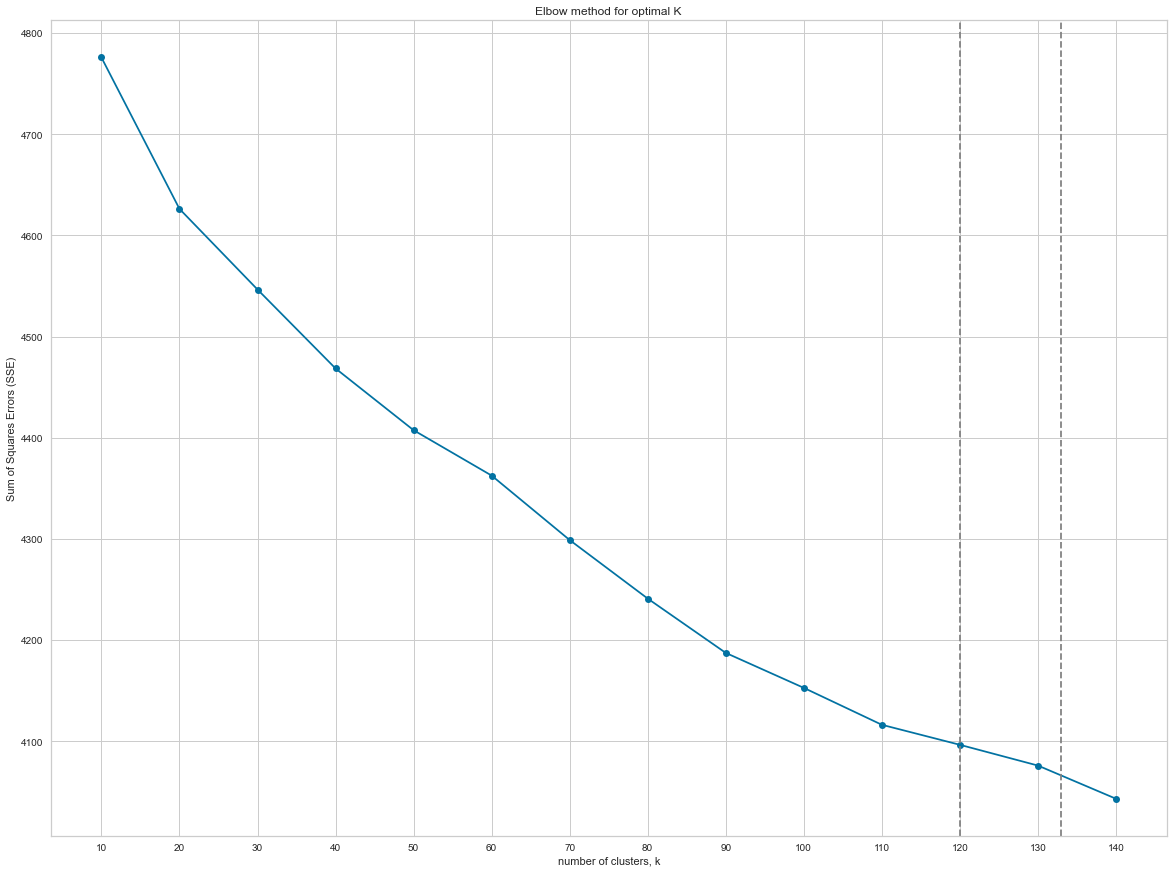

In [197]:
# Run elbows in groups of 10
# Limit to a max of the total num cases
ks = [i * 10 if i*10 < len(grouped_df) else len(grouped_df) for i in range(1,15)]
sse = []
 
for k in ks:
    model =  KMeans(
        n_clusters=k, 
        init='k-means++',
        max_iter=100,
        n_init=1)
 
    model.fit(X)
 
    sse.append(model.inertia_)
     
# Plot ks vs SSE
plt.plot(ks, sse, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Sum of Squares Errors (SSE)')
plt.title('Elbow method for optimal K')
plt.axvline(x=120,linestyle='--',c='grey')
plt.axvline(x=133,linestyle='--',c='grey')
plt.xticks(ks)
plt.show()

# silhoutte_score
#https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6

In [198]:
range_n_clusters = [70, 80, 90, 100, 110, 120, 130, 133,140]
for n_clusters in range_n_clusters:
    #Initializing the clusterer with n_clusters value and a random   generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    #The silhouette_score gives the average value for all the   samples.
    #Calculating number of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)
    #Using Silhouette Plot
    #visualizer = SilhouetteVisualizer(clusterer,colors =  'yellowbrick')
    #Fit the data to the visualizer
    #visualizer.fit(X)       
    #Render the figure
    #visualizer.show()

For n_clusters = 70 The average   silhoutte_score is : 0.03299201581403398
For n_clusters = 80 The average   silhoutte_score is : 0.03743741775282532
For n_clusters = 90 The average   silhoutte_score is : 0.036813221898297284
For n_clusters = 100 The average   silhoutte_score is : 0.03845693066491488
For n_clusters = 110 The average   silhoutte_score is : 0.03835159171523974
For n_clusters = 120 The average   silhoutte_score is : 0.03886827153098639
For n_clusters = 130 The average   silhoutte_score is : 0.04289388597130688
For n_clusters = 133 The average   silhoutte_score is : 0.044121823678229664
For n_clusters = 140 The average   silhoutte_score is : 0.04313388225919396


# KMEANS 

In [199]:
# define number of categories (clusters)
k = 133
 
# Instantiate the model
model = KMeans(
    n_clusters=k, 
    init='k-means++', 
    max_iter=100, 
    n_init=1,
random_state=42)
 
# Train the model on X
model.fit(X)

KMeans(max_iter=100, n_clusters=133, n_init=1, random_state=42)

In [200]:
# assign predicted clusters
labels = model.labels_
#print(len(labels)) 
# create a dataframe that contains 
# clusters matched to pages and their queries 
mapping = list(zip(labels, grouped_df.index, queries))
clusters = pd.DataFrame(mapping, columns=['cluster','Session_Id','Case_title'])
clusters.head(10)

,cluster,Session_Id,Case_title
0,119,1646096681065917,Security Alert for connectivity from AWS acco...
1,11,1646096936896602,Cluster crash weekly
2,6,1646098742869832,Trying to connect MicroStrategy iserver DB con...
3,81,1646098948333606,Databricks Shard Upgrade 3.60 Support!
4,106,1646101058033796,ARR | 2202280060001228 | RCA | Job that was tr...
5,100,1646101446712964,After purging cluster logs there is no signif...
6,0,1646108145921591,2201250060001153 2202240030000948
7,11,1646111416608240,ARR followup 00132690
8,87,1646111830399512,Error in data bricks ConnectException: Conne...
9,123,1646112137174593,Integrate Power Apps with Azure Databricks C...


In [201]:
clusters['Case_title']  = clusters['Case_title'].astype(str)

In [202]:
clusters.head(10)

,cluster,Session_Id,Case_title
0,119,1646096681065917,Security Alert for connectivity from AWS acco...
1,11,1646096936896602,Cluster crash weekly
2,6,1646098742869832,Trying to connect MicroStrategy iserver DB con...
3,81,1646098948333606,Databricks Shard Upgrade 3.60 Support!
4,106,1646101058033796,ARR | 2202280060001228 | RCA | Job that was tr...
5,100,1646101446712964,After purging cluster logs there is no signif...
6,0,1646108145921591,2201250060001153 2202240030000948
7,11,1646111416608240,ARR followup 00132690
8,87,1646111830399512,Error in data bricks ConnectException: Conne...
9,123,1646112137174593,Integrate Power Apps with Azure Databricks C...


# BIGRAMS

In [203]:
def find_bigrams(input_list):
    return list(zip(input_list, input_list[1:]))

In [204]:
from nltk import pos_tag, word_tokenize


# What is Dependency Parsing?
Dependency Parsing is the process to analyze the grammatical structure in a sentence and find out related words as well as the type of the relationship between them.

Each relationship:

Has one head and a dependent that modifies the head.
Is labeled according to the nature of the dependency between the head and the dependent. These labels can be found at Universal Dependency Relations.

Simple dependency relation between two words
In the above diagram, there exists a relationship between car and black because black modifies the meaning of car. Here, car acts as the head and black is a dependent of the head. The nature of the relationship here is amod which stands for “Adjectival Modifier”. It is an adjective or an adjective phrase that modifies a noun.

https://towardsdatascience.com/introducing-idea-condensation-5a0c1dbe5cca

In [205]:
# from collections import Counter
# from nltk.tokenize import word_tokenize
 
# my_dict = {}
# n_clusters = clusters['cluster'].unique()
# n=3 
# # for each cluster
# for c in n_clusters: 
#     # 1
#     asset = clusters[clusters['cluster'] == c] 
#     asset = asset['Case_title']
#     m_asset = ' '.join(asset)
#     # 2
#     tokens = word_tokenize(m_asset)
#     # 30
#     words = [word for word in tokens if not word in stops]
#     # 4
#     bigrams = find_bigrams(words)
#     bigrams = list(map(','.join, bigrams))
    
#     bigrams = pos_tag(bigrams)
#     #print(bigrams)
#     print('{:<15} | {:<8} | {:<15} | {:<20}'.format('TOKEN','RELATION','HEAD','CHILDREN'))
#     for (sent,tag) in bigrams:
#         doc = nlp(sent)
#         for token in doc:
#             print("{:<15} | {:<8} | {:<15} | {:<20}"
#             .format(str(token.text), str(token.dep_), str(token.head.text), str([child for child in token.children])))
# #         https://towardsdatascience.com/natural-language-processing-dependency-parsing-cf094bbbe3f7  
#     counts = Counter(word for word,tag in bigrams) #https://www.guru99.com/pos-tagging-chunking-nltk.html
#     most_common = counts.most_common(4)
#     most_freq = ",".join([bigram[0] for bigram in most_common])
#     my_dict[c] = most_freq
     
# # my_dict


# for i,e in enumerate(my_dict.keys()):
#     doc = my_dict[i]
#     displacy.render(docs=nlp(doc),style="dep")
#     print(i)


In [206]:
# # dependency visualization

# # show visualization in Jupyter Notebook
# doc = nlp("this is an example document")
# displacy.render(docs=doc, style='dep', jupyter=True)

# BIGRAM FORMATION WITHIN THE TITLE

In [207]:
from collections import Counter
from nltk.tokenize import word_tokenize
 
my_dict1 = {}
n_clusters = clusters['cluster'].unique()
n=3 
# for each cluster
for c in n_clusters: 
    # 1
    asset = clusters[clusters['cluster'] == c] 
    asset = asset['Case_title']
    m_asset = ' '.join(asset)
    # 2
    tokens = word_tokenize(m_asset)
    # 3
    words = [word for word in tokens if not word in stops]
    # 4
    bigrams = find_bigrams(words)
    bigrams = list(map(' '.join, bigrams))
    # 5
    counts = Counter(bigrams)
    # 6
    most_common = counts.most_common(4)
    most_freq = [bigram[0] for bigram in most_common]
    # 7
    my_dict1[c] = ','.join(most_freq)
     
my_dict1

{119: 'AWS account,Account Admin,AWS Databricks,AWS MSK',
 11: 'ARR |,] [,| ARR,[ ARR',
 6: 'Unable connect,able connect,Not able,connect Databricks',
 81: 'Databricks Databricks,job failed,Databricks Job,Databricks Cluster',
 106: 'data source,Failed find,find data,ARR |',
 100: 'job cluster,Change data,cluster config,config change',
 0: 'Power BI,using Databricks,Dataset refresh,Read timed',
 87: ': Connection,Connection refused,: [,Connection reset',
 123: 'sql connector,databricks sql,Azure Databricks,Databricks Connector',
 76: 'Remote RPC,RPC client,client disassociated,: Remote',
 132: 'ARR |,error message,error :,error ARR',
 44: 'taking longer,longer time,time start,ARR |',
 18: 'Follow case,ARR |,| ARR,| Follow',
 82: 'Databricks notebook,notebook execution,databricks notebook,execution failure',
 64: 'SF ticket,Followup SF,Follow ticket,follow ticket',
 56: 'instance profile,Instance Profile,No space,space left',
 42: 'Problem reading,A problem,problem Databrick,Databrick se

In [208]:
# Add number of article per cluster
val_count = clusters['cluster'].value_counts()
for i in range(len(val_count)):
    my_dict1[i] += f' ({val_count[i]})'

In [209]:
 my_dict1

{119: 'AWS account,Account Admin,AWS Databricks,AWS MSK (58)',
 11: 'ARR |,] [,| ARR,[ ARR (698)',
 6: 'Unable connect,able connect,Not able,connect Databricks (63)',
 81: 'Databricks Databricks,job failed,Databricks Job,Databricks Cluster (110)',
 106: 'data source,Failed find,find data,ARR | (64)',
 100: 'job cluster,Change data,cluster config,config change (34)',
 0: 'Power BI,using Databricks,Dataset refresh,Read timed (73)',
 87: ': Connection,Connection refused,: [,Connection reset (41)',
 123: 'sql connector,databricks sql,Azure Databricks,Databricks Connector (22)',
 76: 'Remote RPC,RPC client,client disassociated,: Remote (13)',
 132: 'ARR |,error message,error :,error ARR (101)',
 44: 'taking longer,longer time,time start,ARR | (24)',
 18: 'Follow case,ARR |,| ARR,| Follow (72)',
 82: 'Databricks notebook,notebook execution,databricks notebook,execution failure (47)',
 64: 'SF ticket,Followup SF,Follow ticket,follow ticket (28)',
 56: 'instance profile,Instance Profile,No spa

In [210]:
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

# Dimensionality reduction -- PCA

In [211]:
# Dimensionality reduction
# Reduce features to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X.toarray())
 
# Reduce centroids to 2D
reduced_centroids = pca.transform(model.cluster_centers_)
 
print('Tf-IDF feature size: ', X.toarray().shape)
print('PCA feature size: ', reduced_features.shape)
print('Tf-IDF cluster centroids size: ', model.cluster_centers_.shape)
print('PCA centroids size: ', reduced_centroids.shape)

Tf-IDF feature size:  (5020, 5241)
PCA feature size:  (5020, 2)
Tf-IDF cluster centroids size:  (133, 5241)
PCA centroids size:  (133, 2)


# Visualizing more important terms

In [212]:
N_WORDS = 30
mean_data_tfidf = np.array( X.mean( axis=0 ) ).flatten()
vocabulary = vec.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

word_val_data = [ (vocabulary[id], mean_data_tfidf[id]) for id in words_id ]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

Text(0.5, 1.0, 'Top-30 most important words')

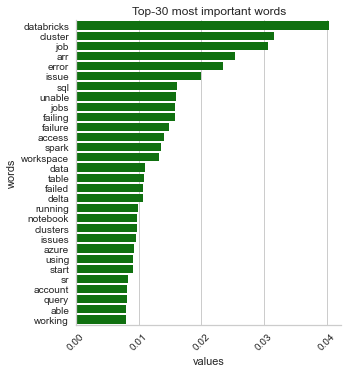

In [213]:
g = sns.catplot(data=word_val_data, color='green',
                 x='values', y='words', kind='bar' )
g.ax.tick_params(axis='x', rotation=45)
g.ax.set_title( f"Top-{N_WORDS} most important words" )

In [214]:
pca_df_scale = pd.DataFrame(reduced_features, columns=['pc1','pc2'])
print(pca.explained_variance_ratio_)
pca_df_scale

[0.01069143 0.00936196]


,pc1,pc2
0,-0.081837,0.003054
1,0.049697,0.177839
2,-0.077343,0.004333
3,-0.064600,0.005378
4,0.157235,0.038889
...,...,...
5015,-0.080877,0.047883
5016,-0.051812,0.042320
5017,-0.007993,-0.043379
5018,-0.032147,-0.024784


In [215]:
Z0 = np.random.normal(0, (1.25, 0.75), (150, 2))  # Z0: 2D random points array
Z1 = Affine2D().rotate_deg(35).transform(Z0)      # Z1: rotated Z0
Zm = Z1.mean(axis=0)

In [216]:
T = np.array(pca_df_scale['pc1'][0], pca_df_scale['pc1'][1])
O = np.array(pca_df_scale['pc2'][0], pca_df_scale['pc2'][1])

In [217]:
import numpy as np
rotation = 180 * np.arctan2(pca_df_scale['pc1'][0], pca_df_scale['pc1'][1]) / np.pi

In [218]:
clusters.Case_title.index

RangeIndex(start=0, stop=5020, step=1)

In [219]:
# predict the labels groupings
predictions = model.predict(X)
predictions

array([119,  11,   6, ..., 130,  11,  78], dtype=int32)

In [220]:
y = model.fit_predict(reduced_features)


In [221]:
import numpy as np
 
print('Number of articles clustered: ', len(predictions))
print('Number of K clusters: ', len(np.unique(predictions)))

Number of articles clustered:  5020
Number of K clusters:  133


# FEATURE EXTRACTION

In [222]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vec.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, predictions, 20)


<AxesSubplot:xlabel='score', ylabel='features'>

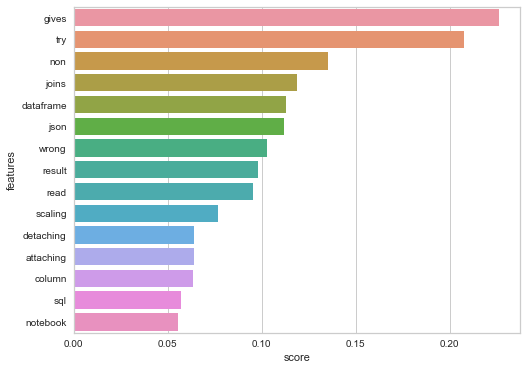

In [223]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])
#https://www.kaggle.com/code/dfoly1/k-means-clustering-from-scratch/notebook#Kmeans-Class

<AxesSubplot:xlabel='score', ylabel='features'>

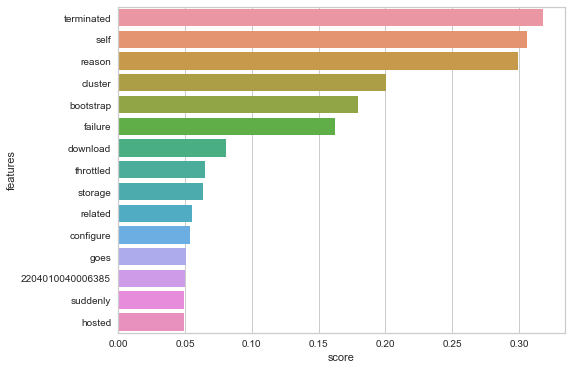

In [224]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

In [225]:
#!pip install chart-studio

In [226]:
from chart_studio import plotly
import plotly.offline as pyoff

# Dimensionality reduction -- PCA Cluster Visualization - Plotly and Matplotlib

In [227]:
layout5 = pgo.Layout(title='(PCA)',
                     xaxis=pgo.XAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     yaxis=pgo.YAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     hovermode='closest'
)

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
 

trace0 = pgo.Scatter(x=reduced_features[:,0],
                     y=reduced_features[:,1],
                     text=clusters.Case_title.index,
                     name='',
                     mode='markers',
                     marker=pgo.Marker(#size=df['tpop10'],
                                       #sizemode='diameter',
                                       #sizeref=df['tpop10'].max()/50,
                                       opacity=0.5,
                                      color = predictions),
                     showlegend=False
                     )

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




In [229]:
# Represent cluster centers.
trace1 = pgo.Scatter(x=reduced_centroids[:, 0],
                     y=reduced_centroids[:,1],
                     #name='',
                     mode='markers',
                     marker=pgo.Marker(symbol='x',
                                       size=12),
                     showlegend=False
)
                     
data7 = pgo.Data([trace0, trace1])
layout7 = layout5
layout7['title'] = 'Potential Category groupings (PCA)'
fig7 = pgo.Figure(data=data7, layout=layout7)

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




In [230]:
pyoff.iplot(fig7, filename='cluster-map')

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



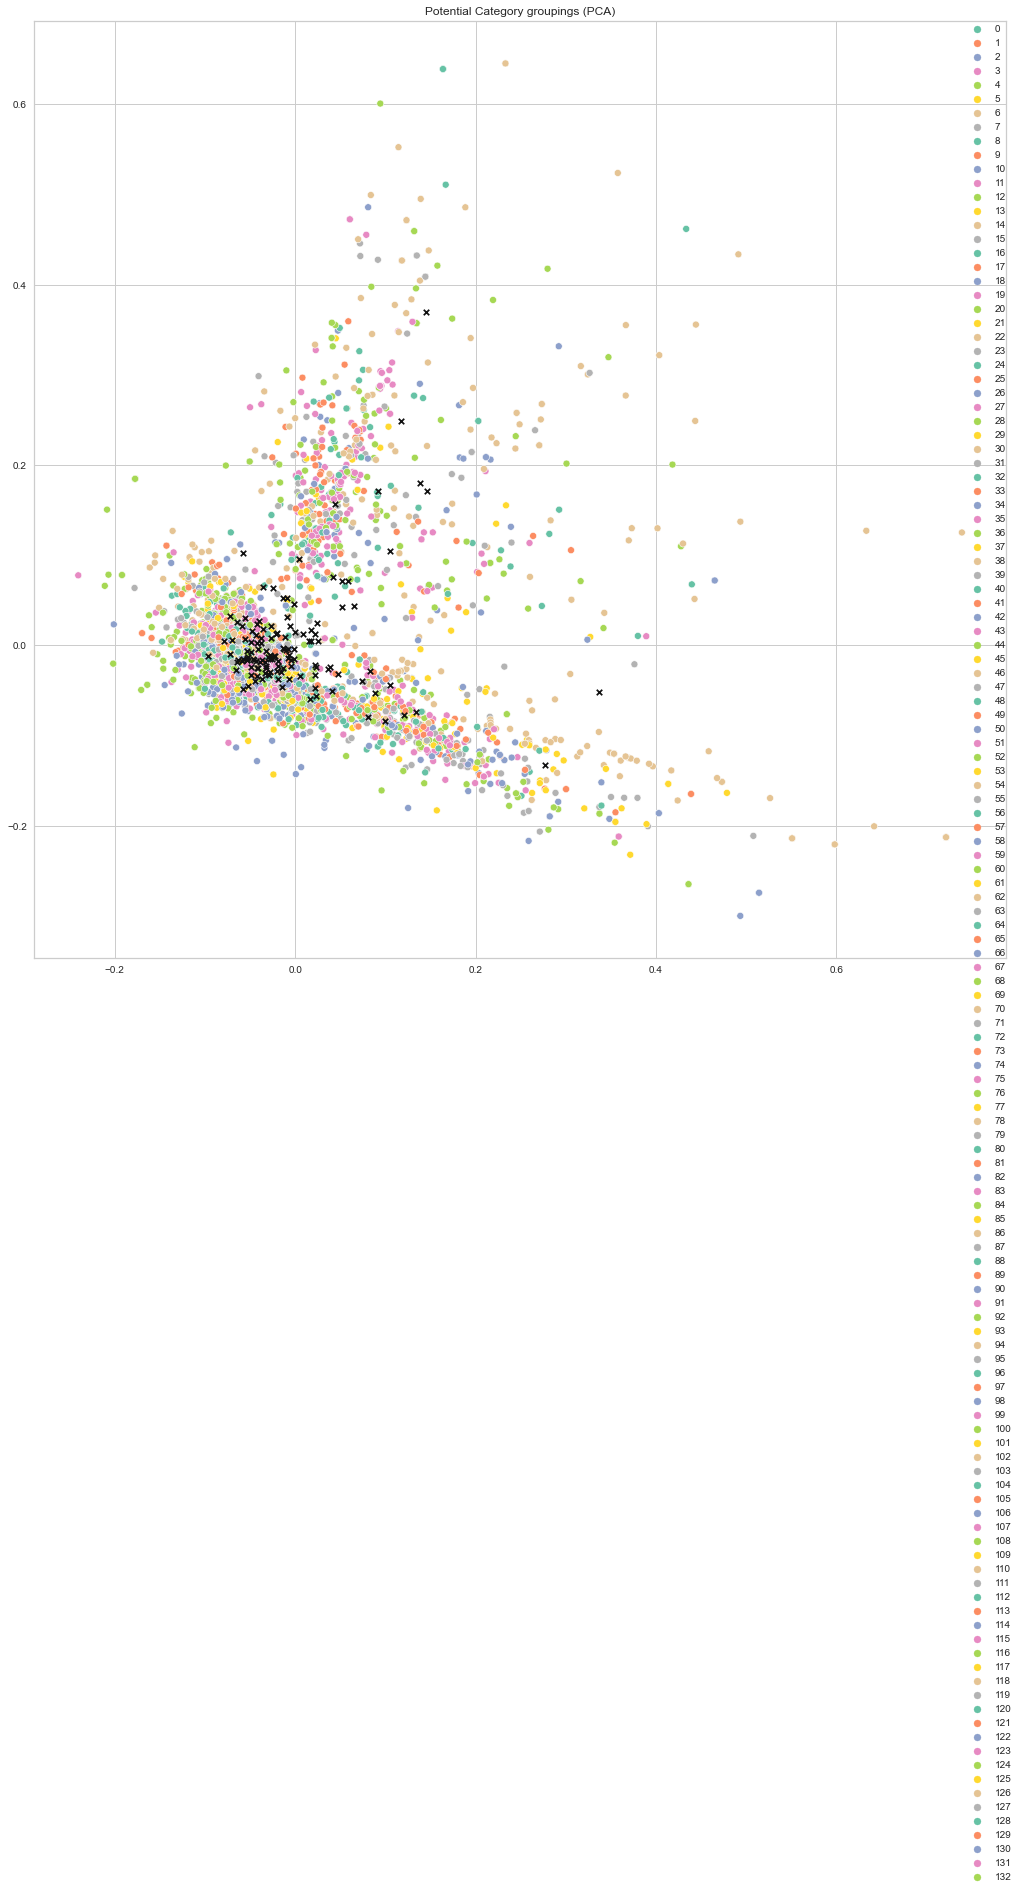

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

# Draw
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.9], aspect=1)

# Plot the individual groupings
# of cases_title

sns.scatterplot(
    x=reduced_features[:,0],
    y=reduced_features[:,1],
    hue=labels,
    palette='Set2')
 
# plot the cluster centroids
#for i in range(5):
ax1.scatter(
    reduced_centroids[:, 0],
    reduced_centroids[:,1],
    marker='x',
    s=30,
    c='k'
    )
 
# plot the graph
ax1.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
#ax1.rcParams["figure.figsize"] = (20, 15)
plt.title('Potential Category groupings (PCA)')
plt.show()



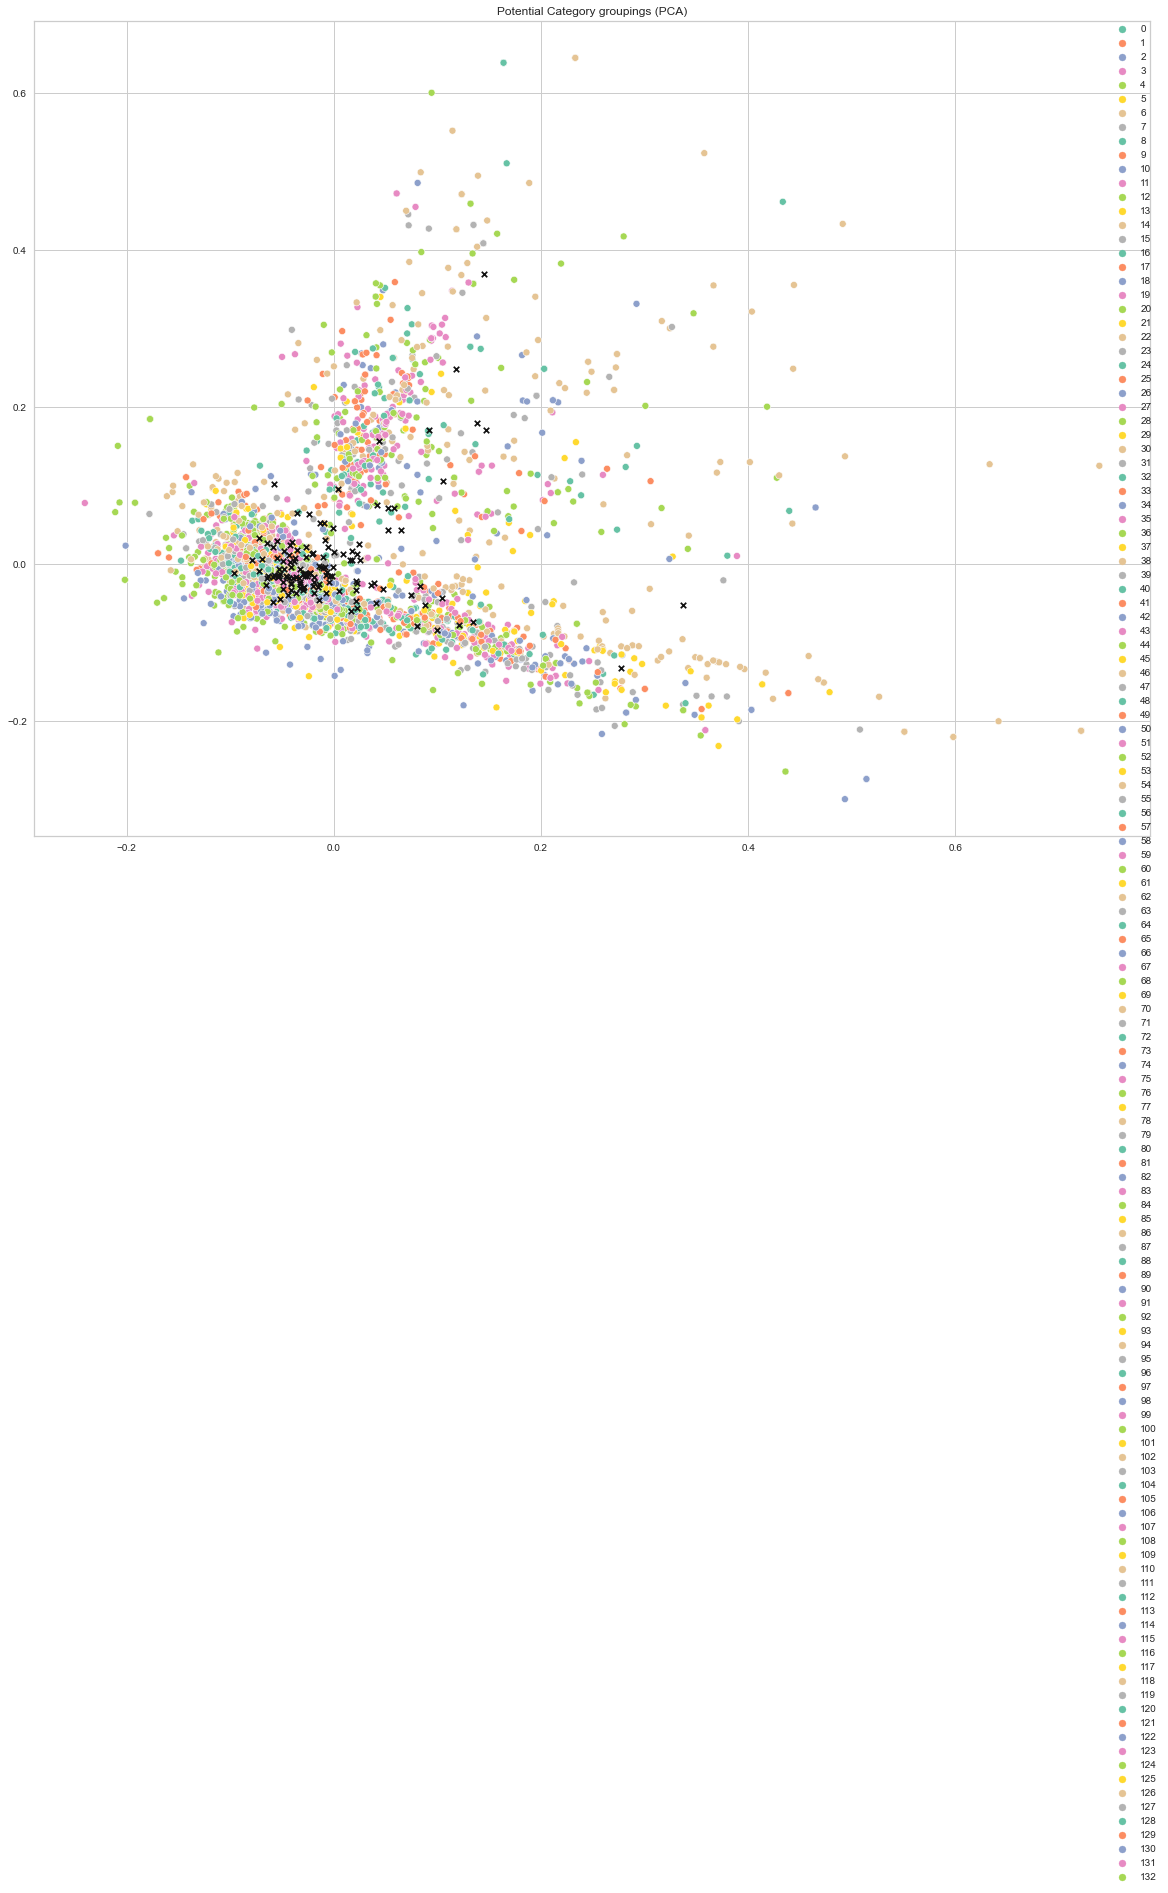

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the individual groupings
# of cases_title

sns.scatterplot(
    x=reduced_features[:,0],
    y=reduced_features[:,1],
    hue=labels,
    palette='Set2')
 
# plot the cluster centroids
#for i in range(5):
plt.scatter(
    reduced_centroids[:, 0],
    reduced_centroids[:,1],
    marker='x',
    s=30,
    c='k'
    )
 
# plot the graph
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
#ax1.rcParams["figure.figsize"] = (20, 15)
plt.title('Potential Category groupings (PCA)')
plt.show()




In [233]:
#https://stackoverflow.com/questions/43254116/labeling-k-means-cluster-data-points-with-matplotlib

# Use the Clustered Data

In [234]:
show_k = 103
 
print('Cluster number: ', show_k)
print('\nTop bigrams: ')
print(my_dict1[show_k])
print('\nTitles in the cluster: ')
pages = clusters['Case_title'][clusters['cluster'] == show_k]
for page in pages:
    print(page)

Cluster number:  103

Top bigrams: 
purpose cluster,All purpose,All Purpose,DBR Job (18)

Titles in the cluster: 
DBR Job hangs  connectivity exceptions in the executors error log
Streaming Hangs
sql query hangs forever
Unknown instance type 'Standard_E16ds_v4'. Assuming 1.0 GB per core for the purpose of computing parquet native reader memory limits
All purpose cluster hangs when mutiple jobs are submitted against the cluster
Unable to increase cluster configuration Jobs hangs randomly   Driver   Executor registration failure.
Spark task hangs  repeating same stage over and over
Query Performs Poorly on Job Cluster  Fine on All Purpose
CSS ARR SR 2204010030001163 Not able to provision the All purpose clusters
All Purpose cluster Slow on GCP
Python virtual env for all purpose and job clusters
Can't see execution plan graph on all purpose cluster
download all records hangs when executing command
Spark Job Hangs Indefinitely when encountering java.nio.file.AccessDeniedException during `i

# Length wise sorting for each cluster


In [235]:
#Length wise sorting for each cluster
cluster_words_splitted = [word.strip() for word in pages]
#print(sorted(cluster_words_splitted, key=len),end="\n\n")
for page in sorted(cluster_words_splitted, key=len):
    print(page)

Streaming Hangs
sql query hangs forever
All purpose cluster   Hangs
All Purpose cluster Slow on GCP
download all records hangs when executing command
Python virtual env for all purpose and job clusters
Spark task hangs  repeating same stage over and over
All Purpose Cluster Is taking very long to Terminate
Can't see execution plan graph on all purpose cluster
Query Performs Poorly on Job Cluster  Fine on All Purpose
DBR Job hangs  connectivity exceptions in the executors error log
ARR   Customer getting error on GUI when viewing all purpose cluster
CSS ARR SR 2204010030001163 Not able to provision the All purpose clusters
All purpose cluster hangs when mutiple jobs are submitted against the cluster
Job processes hangs after a while at an unknown time and does not move forward.
Unable to increase cluster configuration Jobs hangs randomly   Driver   Executor registration failure.
Spark Job Hangs Indefinitely when encountering java.nio.file.AccessDeniedException during `insertInto()` call

In [236]:
page

"Unknown instance type 'Standard_E16ds_v4'. Assuming 1.0 GB per core for the purpose of computing parquet native reader memory limits"

# WORD CLOUD

In [237]:
from wordcloud import WordCloud,STOPWORDS


In [238]:
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon',
                      colormap='Pastel1', collocations=False, stopwords = STOPWORDS, ).generate(page)

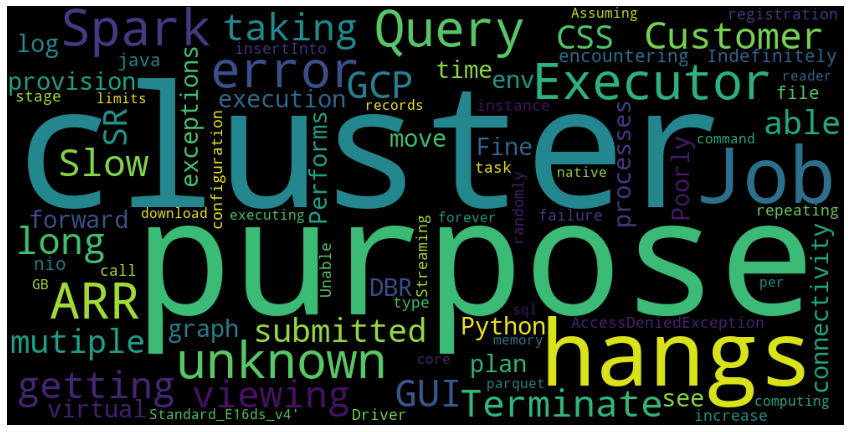

In [239]:
unique_string=(" ").join([page for page in sorted(cluster_words_splitted)])
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()
#please work on https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d

# K NEAREST NEIGBHOR

In [240]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
knn.fit(X)

NearestNeighbors(n_neighbors=10)

In [241]:
knn.kneighbors(X[0:1], return_distance=False)

array([[   0, 3672, 3805,   12, 2245, 1375, 4463, 3482, 1533, 2334]])

In [242]:
knn.kneighbors(X[0:1], return_distance=True)

(array([[0.        , 1.11926123, 1.1519896 , 1.15497388, 1.16219416,
         1.18356219, 1.184135  , 1.19342006, 1.19528998, 1.20796983]]),
 array([[   0, 3672, 3805,   12, 2245, 1375, 4463, 3482, 1533, 2334]]))

In [243]:
input_texts = ['UDF-based External Function not support on SQL Endpoints','Unable to connect ODBC Simba Spark Connector to Databricks SQL End Point']
input_features = vec.transform(input_texts)

D, N = knn.kneighbors(input_features, n_neighbors=2, return_distance=True)

for input_text, distances, neighbors in zip(input_texts, D, N):
    print("Input text = ", input_text[:200], "\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print(clusters['Case_title'][neighbor_idx][:200])
        print("-"*200)
    print("="*200)
    print()

Input text =  UDF-based External Function not support on SQL Endpoints 

Distance =  0.0 Neighbor idx =  3600
UDF based External Function not support on SQL Endpoints
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  1.1099255952533413 Neighbor idx =  2673
SQL endpoints are not working
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Input text =  Unable to connect ODBC Simba Spark Connector to Databricks SQL End Point 

Distance =  0.0 Neighbor idx =  3944
Unable to connect ODBC Simba Spark Connector to Databricks SQL End Point
-----------------------------------------------------------------------------------------------------------------------------------------------------

In [244]:
input_texts1 = [page for page in (cluster_words_splitted)]
input_features2 = vec.transform(input_texts1)
D, N = knn.kneighbors(input_features2, n_neighbors=5, return_distance=True)

for input_text, distances, neighbors in zip(input_texts1, D, N):
    print("Input text = ", input_text[:200], "\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print(f"Cluster Title \n{clusters['Case_title'][neighbor_idx][:500]}")
        print(f"Cluster No ------- {clusters['cluster'][neighbor_idx]}" )
        print("-"*200)
    print("="*200)
    print()
#https://sanjayasubedi.com.np/nlp/nlp-with-python-nearest-neighbor-search/    

Input text =  DBR Job hangs  connectivity exceptions in the executors error log 

Distance =  0.0 Neighbor idx =  57
Cluster Title 
DBR Job hangs  connectivity exceptions in the executors error log
Cluster No ------- 103
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  1.0918802380545334 Neighbor idx =  2422
Cluster Title 
Issue with executors
Cluster No ------- 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  1.141706758724596 Neighbor idx =  251
Cluster Title 
Streaming Hangs
Cluster No ------- 103
-------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Show cluster with the most case_title

In [245]:

lst = list(clusters['cluster'])
largest_cluster = max(lst,key=lst.count)
clusters[clusters['cluster'] == largest_cluster]

,cluster,Session_Id,Case_title
1,11,1646096936896602,Cluster crash weekly
7,11,1646111416608240,ARR followup 00132690
10,11,1646113362326286,2202240030000721001
25,11,1646136526207377,2202240040006086|DukeEnergy|Cluster deletion
26,11,1646142292370596,Broadcast join's are not effecient on the job
...,...,...,...
4989,11,1653994548110429,2205310030000871
5002,11,1654007732150275,Databricks Attempts to Create Clusters in AZ's...
5003,11,1654009227474644,Continuation of 00143942 | The Databricks jo...
5010,11,1654016412364538,Hitting rate limit of 100 nodes per minute.


# Applying KMeans to PCA Principal Components

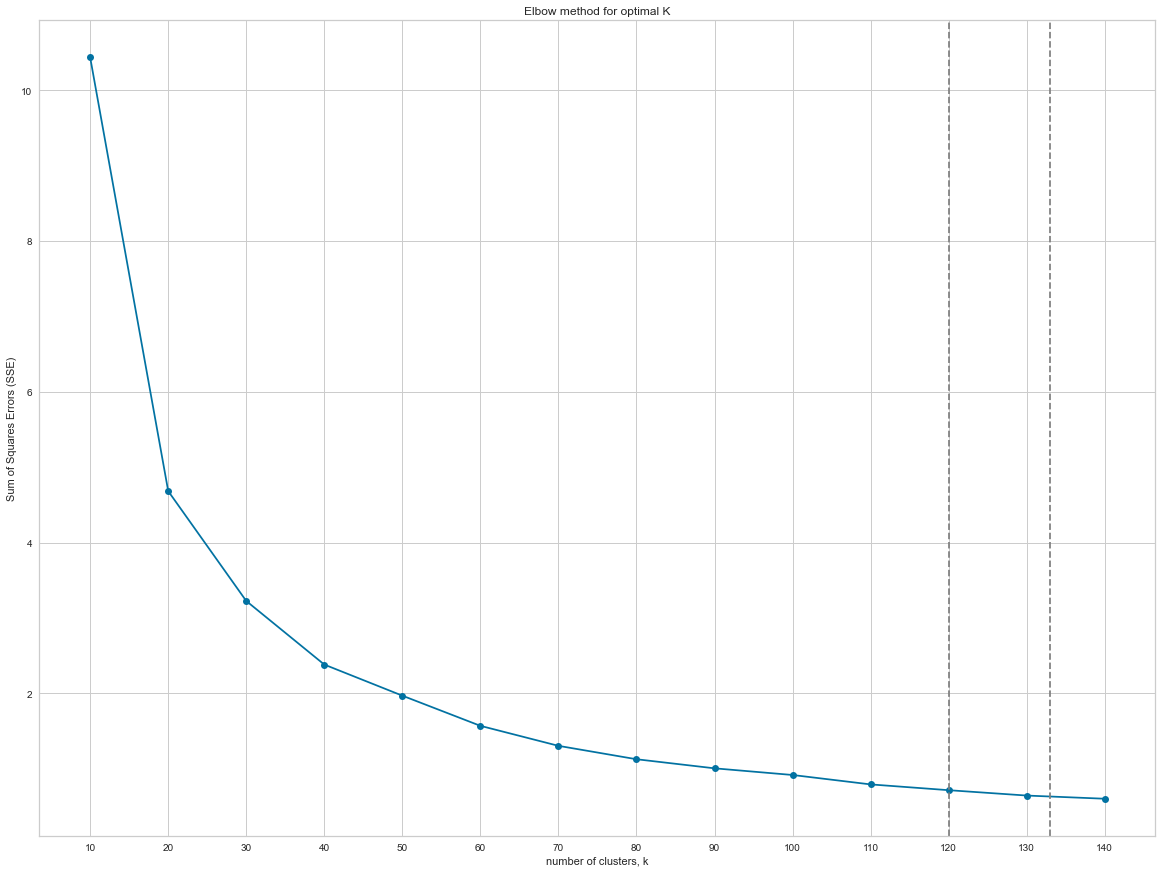

In [246]:
ks = [i * 10 if i*10 < len(grouped_df) else len(grouped_df) for i in range(1,15)]
sse = []
 
for k in ks:
    model =  KMeans(
        n_clusters=k, 
        init='k-means++',
        max_iter=100,
        n_init=1)
 
    model.fit(pca_df_scale)
 
    sse.append(model.inertia_)
     
# Plot ks vs SSE
plt.plot(ks, sse, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Sum of Squares Errors (SSE)')
plt.title('Elbow method for optimal K')
plt.axvline(x=120,linestyle='--',c='grey')
plt.axvline(x=133,linestyle='--',c='grey')
plt.xticks(ks)
plt.show()



In [247]:
range_n_clusters = [30,40,50,60,70,80,90,100,110,120,130,133,140]
for n_clusters in range_n_clusters:
    #Initializing the clusterer with n_clusters value and a random   generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pca_df_scale)
    #The silhouette_score gives the average value for all the   samples.
    #Calculating number of clusters
    silhouette_avg = silhouette_score(pca_df_scale, cluster_labels)
    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)
    #Using Silhouette Plot
    #visualizer = SilhouetteVisualizer(clusterer,colors =  'yellowbrick')
    #Fit the data to the visualizer
    #visualizer.fit(X)       
    #Render the figure
    #visualizer.show()

For n_clusters = 30 The average   silhoutte_score is : 0.40600643624817734
For n_clusters = 40 The average   silhoutte_score is : 0.3557495110706542
For n_clusters = 50 The average   silhoutte_score is : 0.35547869217448713
For n_clusters = 60 The average   silhoutte_score is : 0.3678334408191751
For n_clusters = 70 The average   silhoutte_score is : 0.3700875466368648
For n_clusters = 80 The average   silhoutte_score is : 0.3641707631545878
For n_clusters = 90 The average   silhoutte_score is : 0.3616807203651856
For n_clusters = 100 The average   silhoutte_score is : 0.36110628286752966
For n_clusters = 110 The average   silhoutte_score is : 0.3655340456882411
For n_clusters = 120 The average   silhoutte_score is : 0.36085012155947943
For n_clusters = 130 The average   silhoutte_score is : 0.3649826236434583
For n_clusters = 133 The average   silhoutte_score is : 0.3692147969734104
For n_clusters = 140 The average   silhoutte_score is : 0.35912652739239154


In [248]:
kmeans_pca_scale = KMeans(n_clusters=30, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(pca_df_scale)
print('KMeans PCA Scaled Silhouette Score: {}'.format(silhouette_score(pca_df_scale, kmeans_pca_scale.labels_, metric='euclidean')))
labels_pca_scale = kmeans_pca_scale.labels_
clusters_pca_scale = pd.concat([pca_df_scale, pd.DataFrame({'pca_clusters':labels_pca_scale})], axis=1)

KMeans PCA Scaled Silhouette Score: 0.39074295050737295


In [249]:
# create a dataframe that contains 
# clusters matched to pages and their queries 
mapping = list(zip(labels_pca_scale, grouped_df.index, queries))
clusters1 = pd.DataFrame(mapping, columns=['cluster','Session_Id','Case_title'])
clusters1.head()

,cluster,Session_Id,Case_title
0,0,1646096681065917,Security Alert for connectivity from AWS acco...
1,21,1646096936896602,Cluster crash weekly
2,0,1646098742869832,Trying to connect MicroStrategy iserver DB con...
3,0,1646098948333606,Databricks Shard Upgrade 3.60 Support!
4,20,1646101058033796,ARR | 2202280060001228 | RCA | Job that was tr...


In [250]:
from collections import Counter
from nltk.tokenize import word_tokenize
 
my_dict1 = {}
n_clusters = clusters1['cluster'].unique()
 
# for each cluster
for c in n_clusters: 
    # 1
    asset = clusters1[clusters1['cluster'] == c] 
    asset = asset['Case_title']
    m_asset = ' '.join(asset)
    # 2
    tokens = word_tokenize(m_asset) 
    # 3
    words = [word for word in tokens if not word in stops]
    # 4
    bigrams = find_bigrams(words)
    bigrams = list(map(' '.join, bigrams))
    # 5
    counts = Counter(bigrams)
    # 6
    most_common = counts.most_common(4)
    most_freq = [bigram[0] for bigram in most_common]
    # 7
    my_dict1[c] = ','.join(most_freq)
     
my_dict1

{0: 'ARR |,[ ARR,ARR ],] [',
 21: 'Databricks cluster,Databricks Cluster,ARR |,Not able',
 20: 'ARR |,] [,job cluster,| Job',
 22: 'ARR |,CSS ARR,Databricks cluster,ARR Customer',
 10: '] [,[ ARR,ARR ],ARR |',
 27: '] [,ARR |,[ ARR,ARR ]',
 6: 'Not able,Azure Databricks,ARR Customer,issue Unable',
 18: 'Databricks SQL,SQL Endpoint,Azure SQL,SQL endpoint',
 8: 'jobs failing,ARR |,Jobs failing,[ ARR',
 23: 'job cluster,Job cluster,cluster config,config change',
 28: 'delta table,SQL Endpoint,Delta Live,SQL endpoint',
 24: 'start cluster,Not able,able start,create cluster',
 25: 'Databricks job,ARR |,job failed,job got',
 1: 'Job failure,job failed,Job failing,error message',
 11: 'Databricks Job,Job failing,job failed,| Job',
 4: 'ARR |,Databricks job,[ ARR,ARR ]',
 14: 'Unable access,Unable connect,workspace Unable,Databricks workspace',
 16: '| Job,Job Failure,Job failure,Failure Job',
 26: '[ ARR,ARR ],Bootstrap Timeout,Cluster terminated.Reason',
 5: 'Cluster terminated.Reason,termin

In [251]:
# Add number of article per cluster
val_count = clusters1['cluster'].value_counts()
for i in range(len(val_count)):
    my_dict1[i] += f' ({val_count[i]})'

In [252]:
my_dict1

{0: 'ARR |,[ ARR,ARR ],] [ (572)',
 21: 'Databricks cluster,Databricks Cluster,ARR |,Not able (166)',
 20: 'ARR |,] [,job cluster,| Job (34)',
 22: 'ARR |,CSS ARR,Databricks cluster,ARR Customer (119)',
 10: '] [,[ ARR,ARR ],ARR | (1535)',
 27: '] [,ARR |,[ ARR,ARR ] (425)',
 6: 'Not able,Azure Databricks,ARR Customer,issue Unable (341)',
 18: 'Databricks SQL,SQL Endpoint,Azure SQL,SQL endpoint (168)',
 8: 'jobs failing,ARR |,Jobs failing,[ ARR (235)',
 23: 'job cluster,Job cluster,cluster config,config change (29)',
 28: 'delta table,SQL Endpoint,Delta Live,SQL endpoint (322)',
 24: 'start cluster,Not able,able start,create cluster (35)',
 25: 'Databricks job,ARR |,job failed,job got (163)',
 1: 'Job failure,job failed,Job failing,error message (75)',
 11: 'Databricks Job,Job failing,job failed,| Job (125)',
 4: 'ARR |,Databricks job,[ ARR,ARR ] (169)',
 14: 'Unable access,Unable connect,workspace Unable,Databricks workspace (99)',
 16: '| Job,Job Failure,Job failure,Failure Job (51)'

In [253]:
show_k = 2
 
print('Cluster number: ', show_k)
print('\nTop bigrams: ')
print(my_dict1[show_k])
print('\nTitles in the cluster: ')
pages = clusters['Case_title'][clusters['cluster'] == show_k]
for page in pages:
    print(page)

Cluster number:  2

Top bigrams: 
start cluster,cluster Cluster,issue Cluster,Databricks cluster (52)

Titles in the cluster: 
Cluster terminated.Reason:Spark error
ARR || AT&T || 2204010040006385 || RCA for cluster terminated due to self bootstrap failure
Cluster terminated.Reason:Request Throttled
 Cluster terminated. Reason: Self Bootstrap Failure
Configure Self Managed VPC
Our self hosted Databricks suddenly goes down
[ARR][Cluster terminated.Reason:Storage Download Failure]
Cluster terminated.Reason:Self Bootstrap Failure
Cluster terminated.Reason:Self Bootstrap Failure Cluster terminated.Reason:Self Bootstrap Failure Databricks related queries
Job cluster is slower than interactive cluster Recovery related issue. Cluster terminated.Reason:Storage Download Failure


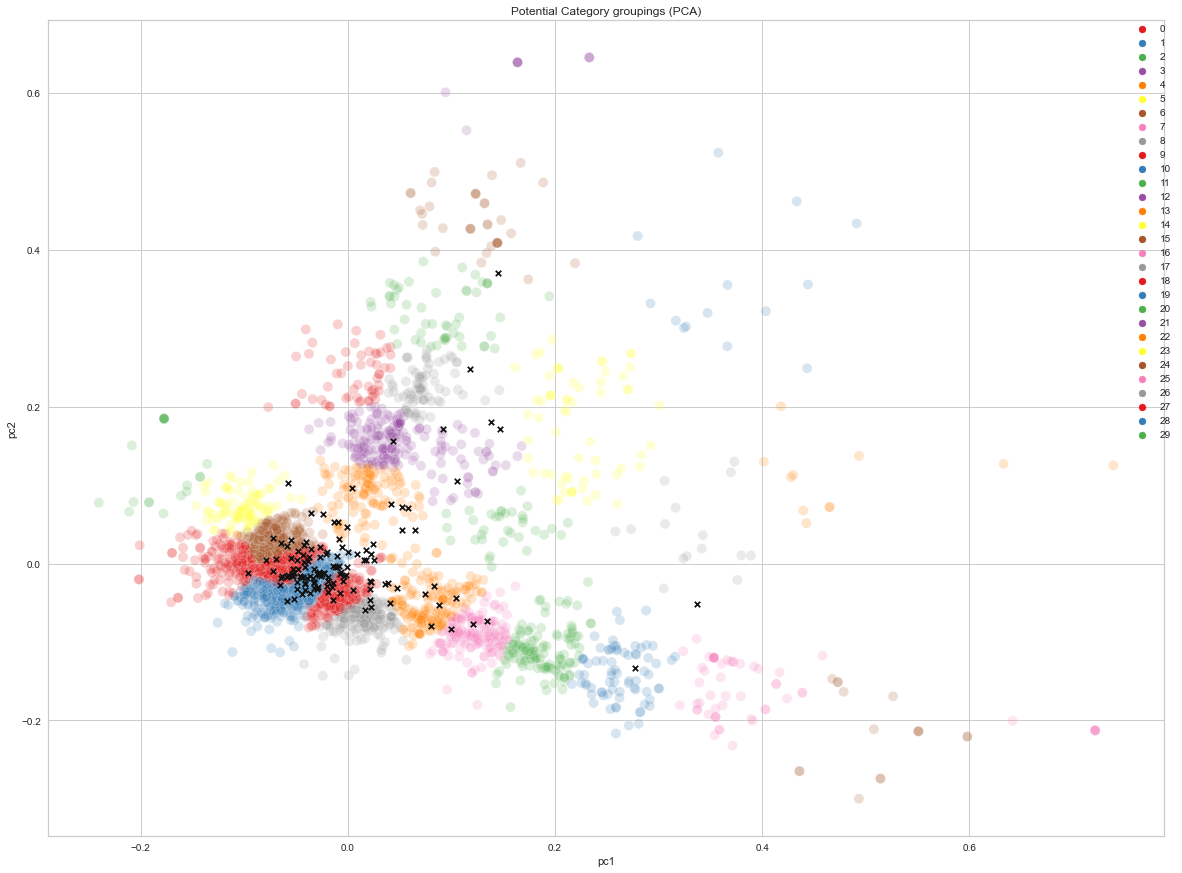

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns
 
 
# Plot the individual groupings
# of cases_title
sns.scatterplot(clusters_pca_scale.iloc[:,0],clusters_pca_scale.iloc[:,1], 
hue=labels_pca_scale, 
palette='Set1', s=100,
alpha=0.2).set_title('KMeans Clusters (30) Derived from PCA', fontsize=15)
 
# plot the cluster centroids
plt.scatter(
    reduced_centroids[:, 0],
    reduced_centroids[:,1],
    marker='x',
    s=30,
    c='k'
    )
 
# plot the graph
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.rcParams["figure.figsize"] = (20, 15)
plt.title('Potential Category groupings (PCA)')
plt.show()




# Topic Modeling using LSI 

In [255]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [256]:
svd = TruncatedSVD(
    n_components=10, # default: 10
)

In [257]:
svd.fit(X)

TruncatedSVD(n_components=10)

In [258]:
def plot_top_words(model, feature_names, n_top_words=10):
  fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle('SVD', fontsize=40)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()

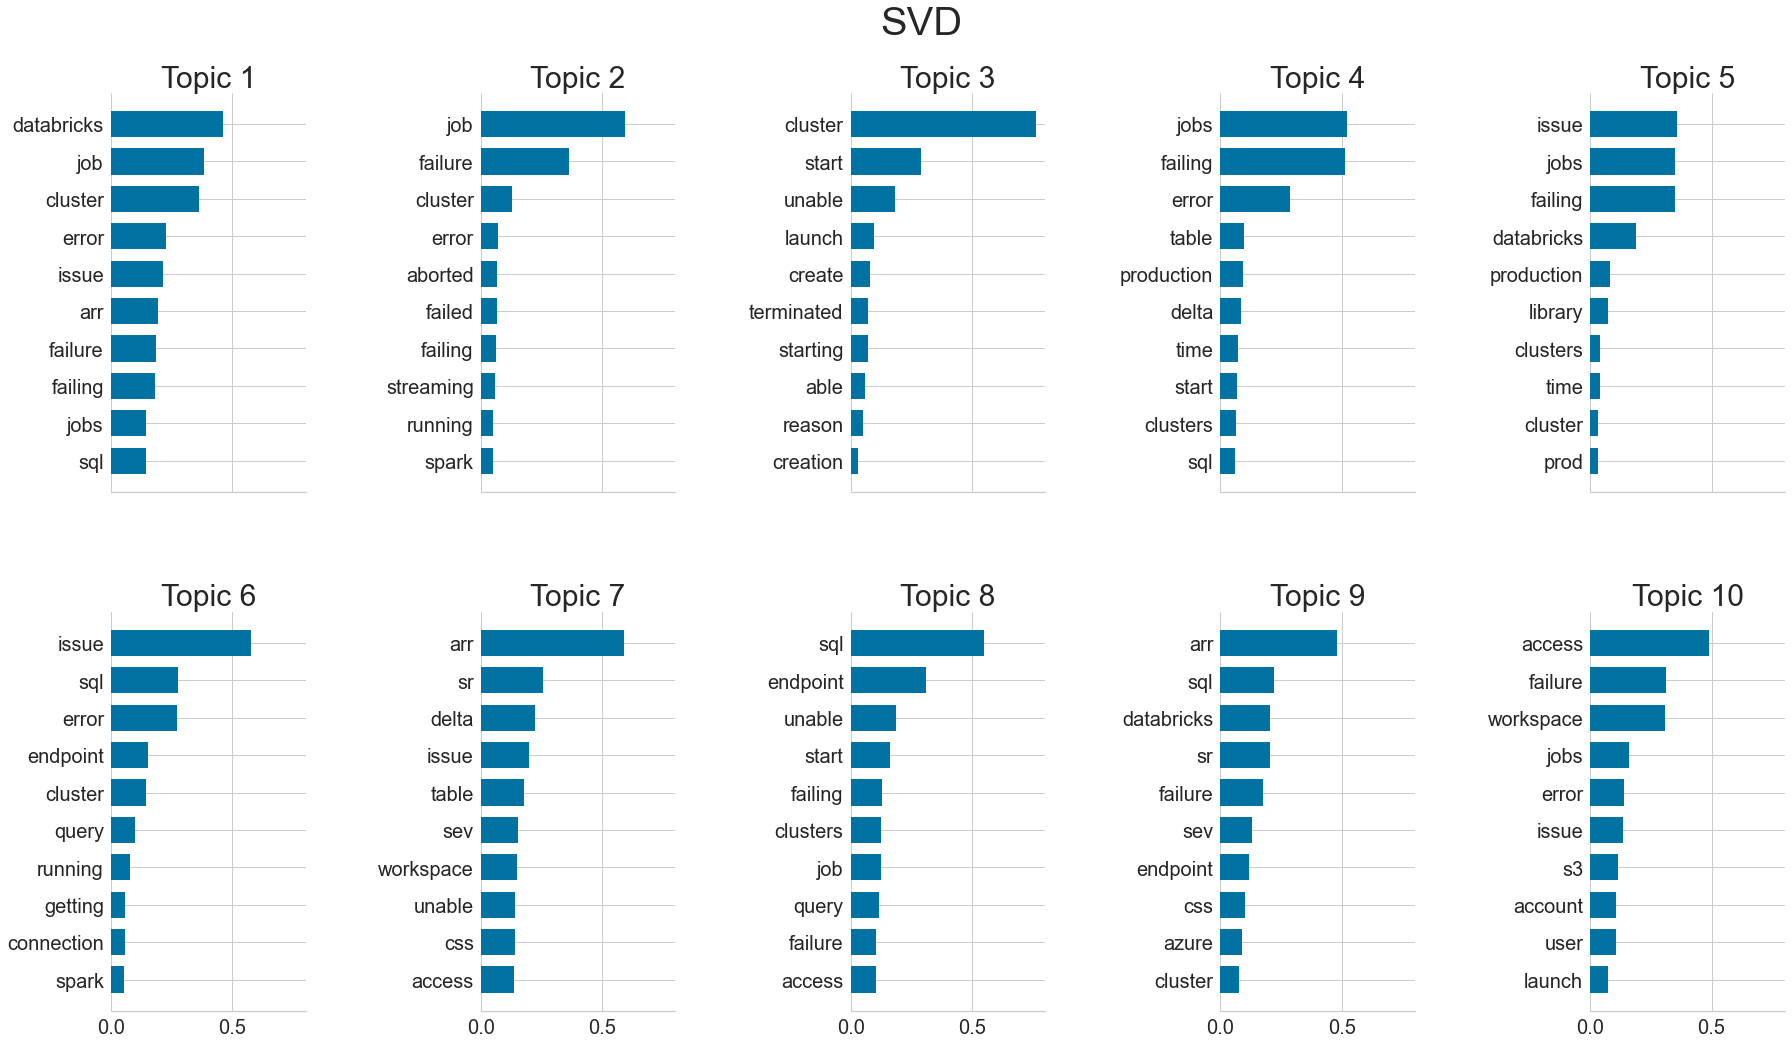

In [259]:
feature_names = vec.get_feature_names()
plot_top_words(svd, feature_names);

In [260]:
Z = svd.transform(X)

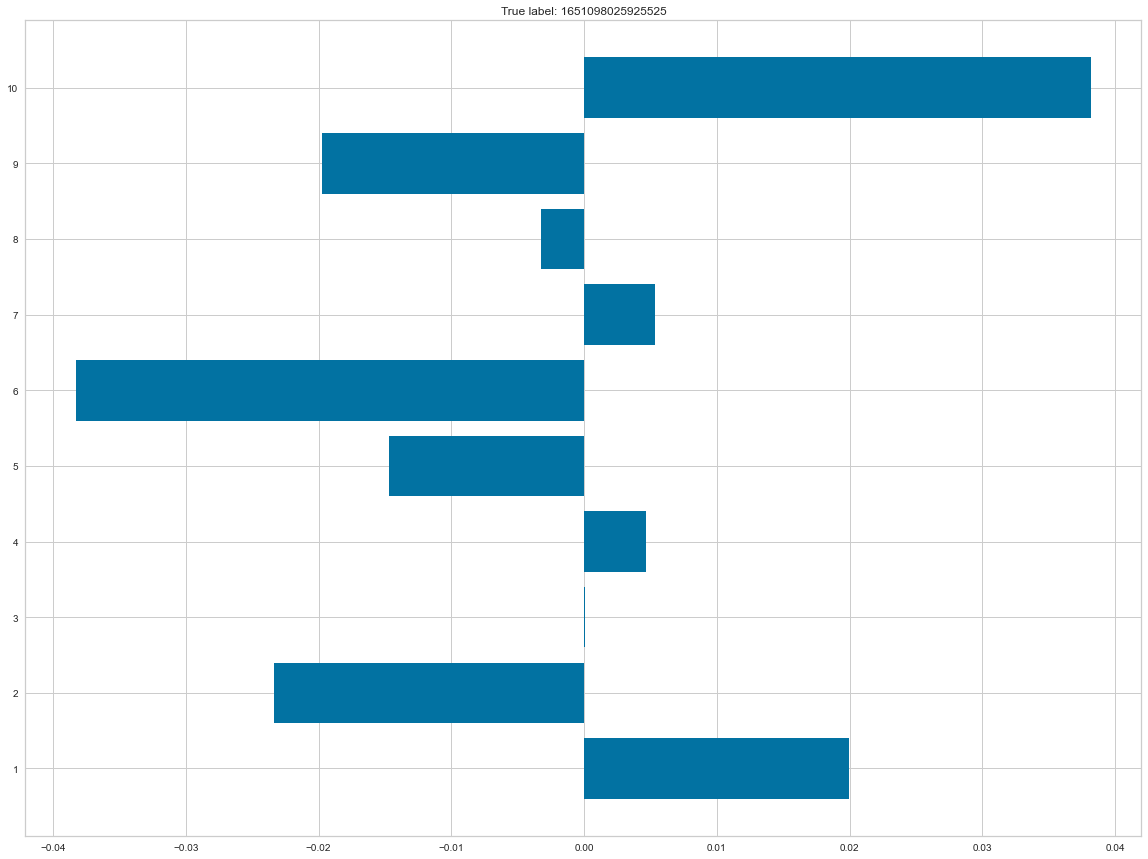

In [261]:
# Pick a random document
# Check which "topics" are associated with it
# Are they related to the true label?

np.random.seed(0)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(10) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['Session_Id']);

# USING BERTopic

In [262]:
type(df1.Case_title)

pandas.core.series.Series

In [263]:
titles = df1.Case_title.to_list()

In [264]:
# Train Model
topic_model = BERTopic(min_topic_size=70, n_gram_range=(1,3), verbose=True)
topics, _ = topic_model.fit_transform(titles)

Batches:   0%|          | 0/176 [00:00<?, ?it/s]

2022-07-04 08:31:42,344 - BERTopic - Transformed documents to Embeddings
2022-07-04 08:31:47,712 - BERTopic - Reduced dimensionality
2022-07-04 08:31:47,972 - BERTopic - Clustered reduced embeddings


In [265]:
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,1850,-1_to_databricks_for_the
1,0,519,0_cluster_clusters_to_start
2,1,410,1_databricks_to_in_in databricks
3,2,395,2_arr_sr_sev_arr sev
4,3,363,3_job_jobs_failing_to
5,4,289,4_sql_endpoint_query_sql endpoint
6,5,276,5_genie_gennie_access_2204110040000576
7,6,262,6_spark_job_streaming_to
8,7,200,7_delta_delta table_table_tables
9,8,182,8_s3_aws_bucket_terraform


In [266]:
topic_nr = freq.iloc[6]["Topic"] # select a frequent topic
topic_model.get_topic(topic_nr)

[('genie', 0.0449465413590197),
 ('gennie', 0.030067724848831353),
 ('access', 0.028027084009508114),
 ('2204110040000576', 0.024804973265592632),
 ('2205100040004471', 0.024054179879065083),
 ('2205110040001203', 0.024054179879065083),
 ('access request', 0.023440834201584274),
 ('2204110040000576 private endpoint', 0.019329800989585904),
 ('geine', 0.019329800989585904),
 ('geni access', 0.019329800989585904)]

In [267]:
topic_model.visualize_topics()

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [268]:
#https://towardsdatascience.com/dynamic-topic-modeling-with-bertopic-e5857e29f872

#Expanding Contractions: Contractions are shortened versions of words or syllables. They are created by removing, one or more letters from words. More often than not, multiple words are combined to create a contraction. For example, I will is contracted into I’ll, do not into don’t. We wouldn’t want our model to consider I will and I’ll differently. Hence, we will convert each contraction into its expanded form using the below-mentioned code.

# Levenshtein Distance
First, we have to create our Levenshtein similarity. I also propose a Weighted Levenshtein similarity, based on the text length, just for experimentation.

In [269]:
# def levenshtein(texts):
#     '''
#     Levenshtein Distance
#     - It requires negative similarities, so -1 * levenshtein(t1, t2)
#     '''
#     texts = np.asarray(texts, dtype=object)
#     _similarity = np.array([[distance.levenshtein(list(w1),list(w2)) for w1 in texts] for w2 in texts])
#     _similarity = -1*_similarity
#     return _similarity

# Clustering
At last, we can define our Text Clustering algorithm, using a similarity function and the Affinity Propagation for the clustering.

Also, I defined a word_level parameter to say whether we have to compute in character-level or compute in word-level. It is recommended compute in word-level when you have a lot of long texts that usually have similar words. Thus, you uses word-level to compare texts by words instead of characters. For example, we are going to use character-level in fake names, and word-level in Medium texts.

https://www.kaggle.com/code/leomauro/text-clustering-grouping-texts

In [270]:
# def text_clustering(texts, similarity=levenshtein, word_level=False):
#     '''Text Clustering'''
#     # similarity
#     if word_level: texts = [t.split() for t in texts]
#     _similarity = levenshtein(texts)
#     _affprop = AffinityPropagation(affinity="precomputed", damping=0.5, verbose=True,
#         random_state=0, max_iter=1_000, convergence_iter=10)
#     _affprop.fit(_similarity)
#     return _affprop, _similarity


# def print_clusters(affprop, texts):
#     '''Print clusters'''
#     texts = np.asarray(texts)
#     clusters = np.unique(affprop.labels_)
#     print(f'\n~ Number of texts:: {texts.shape[0]}')
#     print(f'~ Number of clusters:: {clusters.shape[0]}')
#     if clusters.shape[0] < 2: return 'Only few clusters - Stopped'
#     for cluster_id in clusters:
#         exemplar = texts[affprop.cluster_centers_indices_[cluster_id]]
#         cluster = np.unique(texts[np.nonzero(affprop.labels_==cluster_id)])
#         cluster_str = '";\n  "'.join(cluster)
#         print(f'\n# Cluster ({cluster_id}) with ({len(cluster)}) elements')
#         print(f'Exemplar:: {exemplar}')
#         print(f'\nOthers::\n  "{cluster_str}"')

In [271]:
# texts = df['Case_title']
# affprop, _ = text_clustering(texts, similarity=levenshtein)
# print_clusters(affprop, texts)

In [272]:
import contractions

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stops]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['Case_title']))
len(norm_corpus)

7609

In [273]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(ngram_range=(2, 3), min_df=0.001, max_df=0.99, stop_words=stops)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(7609, 272)

In [274]:
NUM_CLUSTERS = 140
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(cv_matrix)
km

KMeans(max_iter=10000, n_clusters=140, n_init=100, random_state=42)

In [275]:
df['kmeans_cluster'] = km.labels_

In [276]:
article_clusters = (df[['Case_title', 'kmeans_cluster', 'Session_Id']]
                  .sort_values(by=['kmeans_cluster', 'Session_Id'], 
                               ascending=False)
                  .groupby('Session_Id').head(20))
article_clusters = article_clusters.copy(deep=True)

# POPULAR TITLES USING KMEANS 

In [277]:
feature_names = cv.get_feature_names()
topn_features = 30
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get movies belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    movies = article_clusters[article_clusters['kmeans_cluster'] == cluster_num]['Case_title'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('-----------------------------------------------------------------')
    print('Key Features:', key_features)
    print('-----------------------------------------------------------------')
    print('Popular Title:', movies)
    print('-'*80)

CLUSTER #1
-----------------------------------------------------------------
Key Features: ['dataset refresh', 'power bi', 'using databricks', 'writing data', 'dbr 91', 'databricks sql', 'databricks sql endpoint', 'databricks using', 'databricks workspace', 'dbr 104', 'delta lake', 'databricks notebooks', 'delta live', 'delta live table', 'delta live tables', 'delta table', 'delta tables', 'databricks runtime', 'databricks jobs failing', 'databricks notebook', 'due stage', 'databricks jobs', 'databricks job failed', 'databricks job', 'databricks issue', 'databricks connect', 'databricks clusters', 'databricks cluster', 'databricks azure', 'databricks api']
-----------------------------------------------------------------
Popular Title: ['dataset refresh failing', 'Getting Dataset refresh issue in Power BI dashboard', 'dataset refresh failing', 'dataset refresh failing', 'dataset refresh failing', 'Getting Dataset refresh issue in Power BI dashboard', 'Dataset refresh in Power BI Servic